# Final Project
## Dataset:
https://archive.ics.uci.edu/ml/datasets/adult  
* Classification to predict based on features whether an adult earns over $50K a year or not
* Clustering to find groups and similarities between them

**age:** continuous.  
**workclass:** Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked.  
**fnlwgt:** continuous.  
**education:** Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool.  
**education-num:** continuous.  
**marital-status:** Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse.  
**occupation:** Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces.  
**relationship:** Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried.  
**race:** White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black.  
**sex:** Female, Male.  
**capital-gain:** continuous.  
**capital-loss:** continuous.  
**hours-per-week:** continuous.  
**native-country:** United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

In [1]:
# Imports
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics, model_selection, linear_model, feature_selection, preprocessing
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from scipy import stats
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data = pd.read_csv("adult.csv")
display(data.head())
np.shape(data)[0]

age          workclass   fnlwgt   education   education-num  \
0   39          State-gov    77516   Bachelors              13   
1   50   Self-emp-not-inc    83311   Bachelors              13   
2   38            Private   215646     HS-grad               9   
3   53            Private   234721        11th               7   
4   28            Private   338409   Bachelors              13   

        marital-status          occupation    relationship    race      sex  \
0        Never-married        Adm-clerical   Not-in-family   White     Male   
1   Married-civ-spouse     Exec-managerial         Husband   White     Male   
2             Divorced   Handlers-cleaners   Not-in-family   White     Male   
3   Married-civ-spouse   Handlers-cleaners         Husband   Black     Male   
4   Married-civ-spouse      Prof-specialty            Wife   Black   Female   

    capital-gain   capital-loss   hours-per-week  native-country  income  
0           2174              0               40   United-States   <=50K  
1              0              0               13   United-States   <=50K  
2              0              0               40   United-States   <=50K  
3              0              0               40   United-States   <=50K  
4              0              0               40            Cuba   <=50K

48842

## Data Cleaning and EDA

In [3]:
old_value_instances = data.apply(lambda x : dict(x.value_counts()))

In [4]:
data.columns = data.columns.str.strip()
data = data.apply(lambda x : x.astype(str).str.strip(' .') if not pd.api.types.is_int64_dtype(x) else x)

In [5]:
# Count number of instances of missing values
data.loc[:, (data == '?').any()].apply(lambda x : x.value_counts()).head()

workclass  occupation  native-country
?                2799.0      2809.0           857.0
Adm-clerical        NaN      5611.0             NaN
Armed-Forces        NaN        15.0             NaN
Cambodia            NaN         NaN            28.0
Canada              NaN         NaN           182.0

In [6]:
# drop rows with missing values
data = data.replace('?', np.nan).dropna()
display(data.head())
np.shape(data)[0]

age         workclass  fnlwgt  education  education-num  \
0   39         State-gov   77516  Bachelors             13   
1   50  Self-emp-not-inc   83311  Bachelors             13   
2   38           Private  215646    HS-grad              9   
3   53           Private  234721       11th              7   
4   28           Private  338409  Bachelors             13   

       marital-status         occupation   relationship   race     sex  \
0       Never-married       Adm-clerical  Not-in-family  White    Male   
1  Married-civ-spouse    Exec-managerial        Husband  White    Male   
2            Divorced  Handlers-cleaners  Not-in-family  White    Male   
3  Married-civ-spouse  Handlers-cleaners        Husband  Black    Male   
4  Married-civ-spouse     Prof-specialty           Wife  Black  Female   

   capital-gain  capital-loss  hours-per-week native-country income  
0          2174             0              40  United-States  <=50K  
1             0             0              13  United-States  <=50K  
2             0             0              40  United-States  <=50K  
3             0             0              40  United-States  <=50K  
4             0             0              40           Cuba  <=50K

45222

In [7]:
income_count = pd.pivot_table(data, values='workclass', index='income', aggfunc='count')
income_count.rename(columns={'workclass':'count'}, inplace=True)
fig = px.bar(income_count, y='count', title='Count of Each Income Group')
fig.show()

From the original dataset, we can see that there is a significant class imbalance. There are much more instances for the majority class, people whose income is less than 50K, than for the minority class, people whose income is more than 50K. Using a dataset with imbalanced classes may result in lower accuracy.

In [8]:
data['income-binary'] = pd.get_dummies(data['income'])['>50K']
data.head()

age         workclass  fnlwgt  education  education-num  \
0   39         State-gov   77516  Bachelors             13   
1   50  Self-emp-not-inc   83311  Bachelors             13   
2   38           Private  215646    HS-grad              9   
3   53           Private  234721       11th              7   
4   28           Private  338409  Bachelors             13   

       marital-status         occupation   relationship   race     sex  \
0       Never-married       Adm-clerical  Not-in-family  White    Male   
1  Married-civ-spouse    Exec-managerial        Husband  White    Male   
2            Divorced  Handlers-cleaners  Not-in-family  White    Male   
3  Married-civ-spouse  Handlers-cleaners        Husband  Black    Male   
4  Married-civ-spouse     Prof-specialty           Wife  Black  Female   

   capital-gain  capital-loss  hours-per-week native-country income  \
0          2174             0              40  United-States  <=50K   
1             0             0              13  United-States  <=50K   
2             0             0              40  United-States  <=50K   
3             0             0              40  United-States  <=50K   
4             0             0              40           Cuba  <=50K   

   income-binary  
0              0  
1              0  
2              0  
3              0  
4              0

get_dummies() will represent instances with income <=50K as 0 and instances with income >50K as 1.

In [9]:
minority_class_instances = data[data['income-binary'] == 1]
minority_class_size = data['income-binary'].value_counts()[1]
majority_class_size = data['income-binary'].value_counts()[0]
num_dup = majority_class_size - minority_class_size
duplicates_df = minority_class_instances.sample(n=num_dup, replace=True)
balanced_df = pd.concat([data, duplicates_df], ignore_index=True)

Therefore, we can use random duplication of instances in the minority class to make both classes have the same number of instances in our new balanced dataset. This allows us to make the comparison later as to whether using the original dataset or the balanced dataset results in better accuracy for our models.

In [10]:
new_income_count = pd.pivot_table(balanced_df, values='workclass', index='income', aggfunc='count')
new_income_count.rename(columns={'workclass':'count'}, inplace=True)
fig = px.bar(new_income_count, y='count', title='Count of Each Income Group (after balancing)')
fig.show()

### Pruning and Correlation Analysis

In [11]:
xtrain_edu, xtest_edu, ytrain_edu, ytest_edu = model_selection.train_test_split(np.array(balanced_df['education-num']), 
                                                                                 np.array(balanced_df['education']),
                                                                                 test_size=0.2,
                                                                                 random_state=0)
bxtrain_edu, bxtest_edu, bytrain_edu, bytest_edu = model_selection.train_test_split(np.array(balanced_df['education-num']), 
                                                                                 np.array(balanced_df['education']),
                                                                                 test_size=0.2,
                                                                                 random_state=0)

In [12]:
clf_edu = linear_model.LogisticRegression(solver='newton-cg').fit(xtrain_edu.reshape(-1, 1), ytrain_edu)
bclf_edu = linear_model.LogisticRegression(solver='newton-cg').fit(bxtrain_edu.reshape(-1, 1), bytrain_edu)

In [13]:
predict_edu = clf_edu.predict(xtest_edu.reshape(-1, 1))
print(f"Test: {predict_edu}\nPrediction: {ytest_edu}\n")
print(f"Accuracy: {metrics.accuracy_score(ytest_edu, predict_edu)}")
print(f"Precision: {metrics.precision_score(ytest_edu, predict_edu, average='macro')}")
print(f"Recall: {metrics.recall_score(ytest_edu, predict_edu, average='macro')}")
# print(f"F1: {metrics.f1_score(ytest_edu, predict_edu, average='macro')}")

Test: ['7th-8th' 'Bachelors' 'Assoc-voc' ... 'HS-grad' 'Doctorate' 'HS-grad']
Prediction: ['7th-8th' 'Bachelors' 'Assoc-voc' ... 'HS-grad' 'Doctorate' 'HS-grad']

Accuracy: 1.0
Precision: 1.0
Recall: 1.0


In [14]:
bpredict_edu = bclf_edu.predict(bxtest_edu.reshape(-1, 1))
print(f"Balanced Test: {bpredict_edu}\nPrediction: {bytest_edu}\n")
print(f"Balanced Accuracy: {metrics.accuracy_score(bytest_edu, bpredict_edu)}")
print(f"Balanced Precision: {metrics.precision_score(bytest_edu, bpredict_edu, average='macro')}")
print(f"Balanced Recall: {metrics.recall_score(bytest_edu, bpredict_edu, average='macro')}")
# print(f"F1: {metrics.f1_score(ytest_edu, predict_edu, average='macro')}")

Balanced Test: ['7th-8th' 'Bachelors' 'Assoc-voc' ... 'HS-grad' 'Doctorate' 'HS-grad']
Prediction: ['7th-8th' 'Bachelors' 'Assoc-voc' ... 'HS-grad' 'Doctorate' 'HS-grad']

Balanced Accuracy: 1.0
Balanced Precision: 1.0
Balanced Recall: 1.0


**Logistic Regression Analyzing Correlation**
* We are trying to determine if `education` and `education-num` are actually correlated and if we can ignore one of them when performing building our models and visualizations. Although based on column names, it's highly likely they are related, we wish to confirm this with correlation analysis. 
* Since `education` is categorical and `education-num` is continuous, we cannot perform Pearson's Correlation or Chi2. Instead, we can utilize *Logistic Regression* to see if the two features are correlated. The `newton-cg` sovler is used as it's the one that best matches our dataset given our sample size and values. We will train this model with `education-num` to classify they're `education`. We'll train it on 80% of the data and test it with the remaining 20%. If the resulting `accuracy`, `precision`, and `recall` is extremely high, we can conclude that `education` and `education-num` are correlated.

*Result:*  
* Accuracy: `1.0`, Balanced = `1.0`
* Precision: `1.0`, Balanced = `1.0`
* Recall: `1.0`, Balanced = `1.0`
* Given that the model was able to predict the test set's `education` with 100% accuracy, we can conclude that our `X` values can accurately classify the values; however, if it's heavily unbalanced, this will be guaranteed near 100%. Precision and recall can be useful as they tell us how relevant our features are at classifying. Given that both of these are `1.0`, we can also determine that our precision-recall is perfect, and that all the features utilized are extremely important in the logistic regression. Moreoever, combining each of these three metrics, it tells us that each of the values in `education-num` is directly translate to a specific value in `education`, i.e. `13` => `Bachelors`. Although with the visible eye, this could seem obvious, this logistic regrssion and the combination of these metrics confirms this hypothesis with all of the values in the dataset. Therefore, we can confirm that `education` and `education-num` are correlated; however, since this value will be important for our kNN model, we will not prune it, rather we will simply ignore it in other usages. The same result can be found with the balanced dataset.

In [15]:
display(pd.crosstab(data['marital-status'], data['relationship']))
chi2_mr, p_mr, df_mr, expected_mr = stats.chi2_contingency(pd.crosstab(data['marital-status'], data['relationship']))

relationship           Husband  Not-in-family  Other-relative  Own-child  \
marital-status                                                             
Divorced                     0           3435             166        429   
Married-AF-spouse           11              0               1          1   
Married-civ-spouse       18655             19             184        125   
Married-spouse-absent        0            282              44         57   
Never-married                0           6691             820       5864   
Separated                    0            588              75        130   
Widowed                      0            687              59         20   

relationship           Unmarried  Wife  
marital-status                          
Divorced                    2267     0  
Married-AF-spouse              0    19  
Married-civ-spouse             0  2072  
Married-spouse-absent        169     0  
Never-married               1223     0  
Separated                    618     0  
Widowed                      511     0

In [16]:
display(pd.crosstab(balanced_df['marital-status'], balanced_df['relationship']))
bchi2_mr, bp_mr, bdf_mr, bexpected_mr = stats.chi2_contingency(pd.crosstab(balanced_df['marital-status'], balanced_df['relationship']))

relationship           Husband  Not-in-family  Other-relative  Own-child  \
marital-status                                                             
Divorced                     0           4354             177        474   
Married-AF-spouse           25              0               1          1   
Married-civ-spouse       35899             28             240        176   
Married-spouse-absent        0            373              48         60   
Never-married                0           7920             844       5999   
Separated                    0            716              82        130   
Widowed                      0            837              61         23   

relationship           Unmarried  Wife  
marital-status                          
Divorced                    2631     0  
Married-AF-spouse              0    42  
Married-civ-spouse             0  4120  
Married-spouse-absent        187     0  
Never-married               1276     0  
Separated                    680     0  
Widowed                      624     0

In [17]:
print(f"Chi2 Value: {chi2_mr}, Balanced = {bchi2_mr}")

Chi2 Value: 53655.73391361823, Balanced = 80507.62498329744


**Chi Square for Pruning**  
* Null Hypothesis: `marital-status` and `relationship` are not correlated
* Significance Level: `0.05`
* DoF: (7-1)(6-1) = `30`
* Critical Value: `43.77`  

*Result:*  
* Chi2 Value: `58195.24158415406`, Balanced = `80494.78403003045`
* In order to fail to reject the null hypothesis, we need our Chi2 Value to be less than `43.77`. However, after performing Chi2 analysis, we get `58195.24158415406`, which is much larger than the `43.77`. This means that we **reject our null hypothesis** that `marital-status` and `relationship` are most definitely correlated, and we can prune one of the features. Likewise, `80494.78403003045` is much greater than the Critical Value, which means they are still not correlated.

In [18]:
# dropping redundant features
data = data.drop(columns=['relationship'])
balanced_df = balanced_df.drop(columns=['relationship'])

In [19]:
value_instances = data.apply(lambda x : dict(x.value_counts()))
bvalue_instances = balanced_df.apply(lambda x : dict(x.value_counts()))

**Correlation Between Other Numerical Data**

In [20]:
# Split data between categorical and numerical data
num_data = data.loc[:, data.dtypes == 'int64']
bnum_data = balanced_df.loc[:, data.dtypes == 'int64']

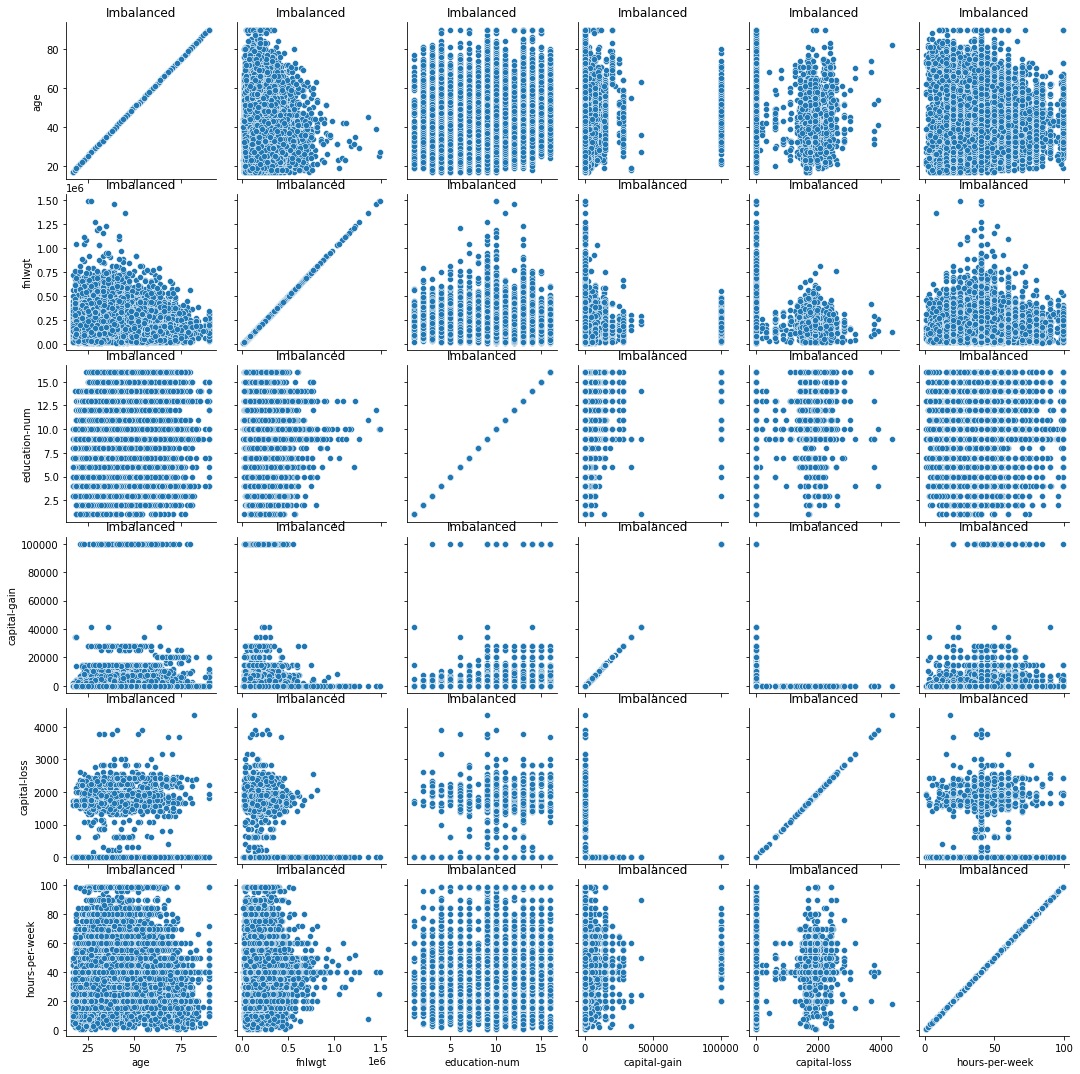

In [21]:
fs_pgplot = sns.PairGrid(data.drop(columns='income-binary'))
fs_pgplot.map(sns.scatterplot).set(title='Imbalanced')

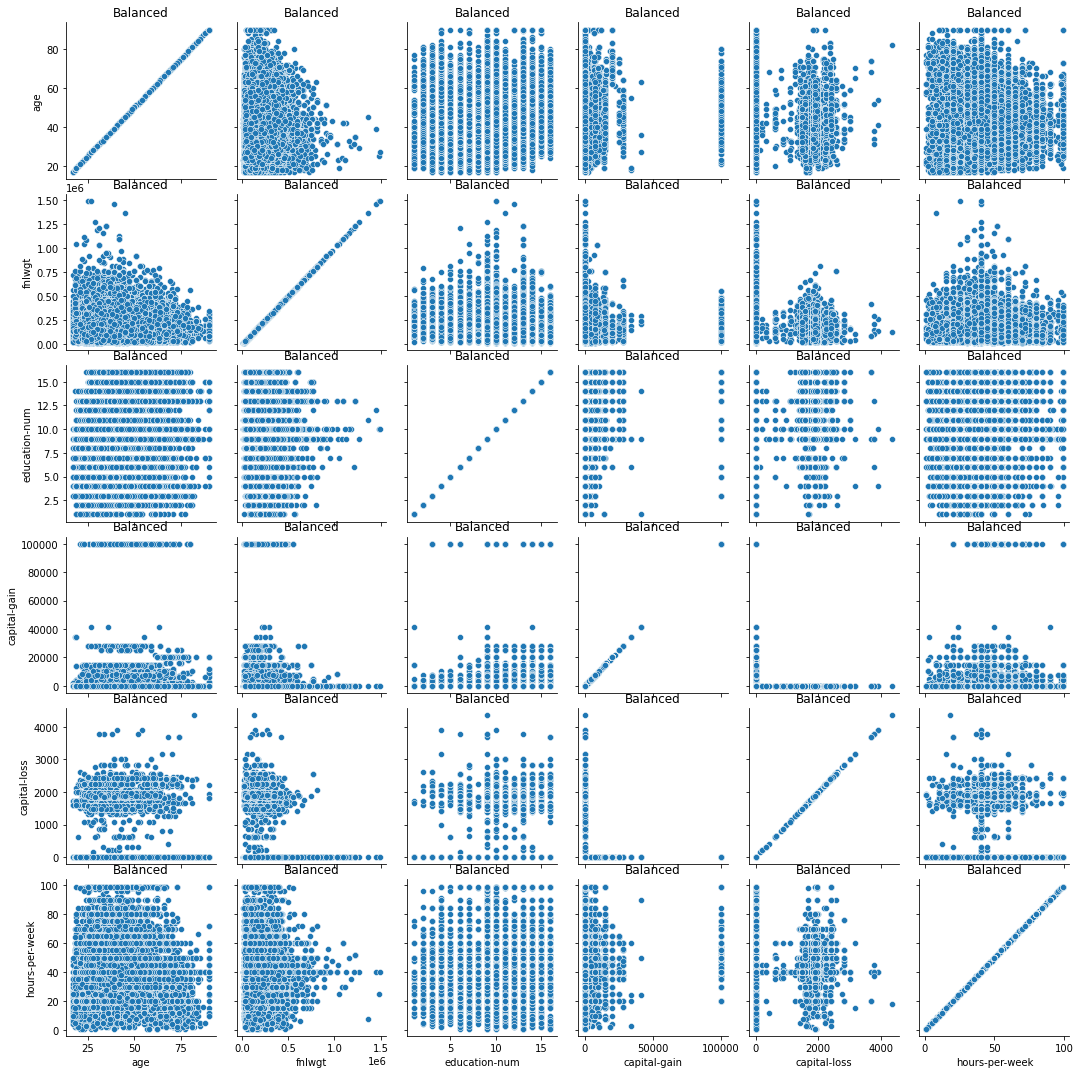

In [22]:
fs_pgplot = sns.PairGrid(balanced_df.drop(columns='income-binary'))
fs_pgplot.map(sns.scatterplot).set(title='Balanced')

In [23]:
num_data.corr(method='pearson')

age    fnlwgt  education-num  capital-gain  capital-loss  \
age             1.000000 -0.075792       0.037623      0.079683      0.059351   
fnlwgt         -0.075792  1.000000      -0.041993     -0.004110     -0.004349   
education-num   0.037623 -0.041993       1.000000      0.126907      0.081711   
capital-gain    0.079683 -0.004110       0.126907      1.000000     -0.032102   
capital-loss    0.059351 -0.004349       0.081711     -0.032102      1.000000   
hours-per-week  0.101992 -0.018679       0.146206      0.083880      0.054195   

                hours-per-week  
age                   0.101992  
fnlwgt               -0.018679  
education-num         0.146206  
capital-gain          0.083880  
capital-loss          0.054195  
hours-per-week        1.000000

In [24]:
bnum_data.corr(method='pearson')

age    fnlwgt  education-num  capital-gain  capital-loss  \
age             1.000000 -0.069189       0.079133      0.087608      0.059301   
fnlwgt         -0.069189  1.000000      -0.026748     -0.000617     -0.003206   
education-num   0.079133 -0.026748       1.000000      0.140562      0.101857   
capital-gain    0.087608 -0.000617       0.140562      1.000000     -0.051096   
capital-loss    0.059301 -0.003206       0.101857     -0.051096      1.000000   
hours-per-week  0.086818 -0.017255       0.163693      0.099293      0.055820   

                hours-per-week  
age                   0.086818  
fnlwgt               -0.017255  
education-num         0.163693  
capital-gain          0.099293  
capital-loss          0.055820  
hours-per-week        1.000000

To see if there is any other correlations between the numerical data, we plotted each numerical feature against each other in a scatter plot to observe any potential correlations. To pair each feature together, `PairGrid` was used with each pair placed in a scatter plot. By looking at the graph, we can see that all the scatter plots show little to no correlation (ignoring the diagonal, which pairs a feature against itself). To confirm the actual values, we also ran Pearson Correlation on each of the pairs and displayed the results in the above matrix. Again, we can see for each pair that there is little to almost no correlation between the two features, with the highest coefficient value in the entire matrix being `0.146206` between `hours-per-week` and `education-num`. With this, we can conclude that none of the *numerical* features are correlated to each other, and that each of these features are relevant. This is the same with the balanced dataset where the highest coefficient is `0.162875`, which is still significantly low.

### EDA

#### Spider Plot Visualization
US vs Non-US in race, education, and marital status 

In [25]:
#comparing united states race vs race of other countries
race_categories = pd.crosstab(data['race'], data['native-country'])
race_categories

native-country      Cambodia  Canada  China  Columbia  Cuba  \
race                                                          
Amer-Indian-Eskimo         0       0      0         1     0   
Asian-Pac-Islander        23       1    110         0     0   
Black                      1       0      0         0     4   
Other                      0       2      0         8     3   
White                      2     160      3        73   126   

native-country      Dominican-Republic  Ecuador  El-Salvador  England  France  \
race                                                                            
Amer-Indian-Eskimo                   0        0            0        0       0   
Asian-Pac-Islander                   1        0            0        2       1   
Black                               18        1            1        8       1   
Other                               21       12            8        1       1   
White                               57       30          138      108      33   

native-country      ...  Portugal  Puerto-Rico  Scotland  South  Taiwan  \
race                ...                                                   
Amer-Indian-Eskimo  ...         0            1         0      2       0   
Asian-Pac-Islander  ...         1            1         0     98      52   
Black               ...         0           13         1      0       0   
Other               ...         1           28         0      0       0   
White               ...        60          132        19      1       3   

native-country      Thailand  Trinadad&Tobago  United-States  Vietnam  \
race                                                                    
Amer-Indian-Eskimo         0                0            417        0   
Asian-Pac-Islander        24                4            398       81   
Black                      1               20           3962        0   
Other                      0                1            168        0   
White                      4                1          36347        2   

native-country      Yugoslavia  
race                            
Amer-Indian-Eskimo           0  
Asian-Pac-Islander           0  
Black                        0  
Other                        0  
White                       23  

[5 rows x 41 columns]

In [26]:
#comparing united states race vs race of other countries
brace_categories = pd.crosstab(balanced_df['race'], balanced_df['native-country'])
brace_categories

native-country      Cambodia  Canada  China  Columbia  Cuba  \
race                                                          
Amer-Indian-Eskimo         0       0      0         1     0   
Asian-Pac-Islander        39       2    192         0     0   
Black                      1       0      0         0     8   
Other                      0       2      0         8     3   
White                      2     288      5        79   198   

native-country      Dominican-Republic  Ecuador  El-Salvador  England  France  \
race                                                                            
Amer-Indian-Eskimo                   0        0            0        0       0   
Asian-Pac-Islander                   1        0            0        2       1   
Black                               19        1            1       13       1   
Other                               21       14            8        7       3   
White                               66       36          146      208      60   

native-country      ...  Portugal  Puerto-Rico  Scotland  South  Taiwan  \
race                ...                                                   
Amer-Indian-Eskimo  ...         0            1         0      5       0   
Asian-Pac-Islander  ...         1            1         0    141      95   
Black               ...         0           18         1      0       0   
Other               ...         1           36         0      0       0   
White               ...        83          170        20      1       6   

native-country      Thailand  Trinadad&Tobago  United-States  Vietnam  \
race                                                                    
Amer-Indian-Eskimo         0                0            510        0   
Asian-Pac-Islander        29                4            636       95   
Black                      1               21           4978        0   
Other                      0                1            210        0   
White                      6                1          56211        2   

native-country      Yugoslavia  
race                            
Amer-Indian-Eskimo           0  
Asian-Pac-Islander           0  
Black                        0  
Other                        0  
White                       43  

[5 rows x 41 columns]

##### Race in United-States vs Non United-States

In [27]:
#table of race with columns united states vs other
race_categories = pd.crosstab(data['race'], data['native-country'] != 'United-States', normalize = 'index')
race_categories = race_categories.rename(columns = {'False' : 'United-States'})
race_categories = race_categories.rename(columns={0: 'United-States', 1: 'Non United-States'})
race_categories

native-country      United-States  Non United-States
race                                                
Amer-Indian-Eskimo       0.958621           0.041379
Asian-Pac-Islander       0.305449           0.694551
Black                    0.937086           0.062914
Other                    0.475921           0.524079
White                    0.934298           0.065702

In [28]:
#table of race with columns united states vs other
brace_categories = pd.crosstab(balanced_df['race'], balanced_df['native-country'] != 'United-States', normalize = 'index')
brace_categories = brace_categories.rename(columns = {'False' : 'United-States'})
brace_categories = brace_categories.rename(columns={0: 'United-States', 1: 'Non United-States'})
brace_categories

native-country      United-States  Non United-States
race                                                
Amer-Indian-Eskimo       0.960452           0.039548
Asian-Pac-Islander       0.307395           0.692605
Black                    0.938891           0.061109
Other                    0.465632           0.534368
White                    0.941952           0.058048

In [29]:
# Imbalanced
spider_graph = go.Figure()
spider_graph.add_trace(go.Scatterpolar(
                    r = race_categories['United-States'],
                    theta = ['Amer-Indian-Eskimo','Asian-Pac-Islander','Black' ,'Other', 'White'],
                    fill = 'toself',
                    name = 'United-States'
))

spider_graph.add_trace(go.Scatterpolar(
                    r = race_categories['Non United-States'],
                    theta = ['Amer-Indian-Eskimo','Asian-Pac-Islander','Black' ,'Other', 'White'],
                    fill = 'toself',
                    name = 'Non United-States'
))


spider_graph.update_layout(
            polar=dict(
            radialaxis=dict(
                visible = True,
                range = [0, 1]
            ),
            ),
    title_text = 'Race in United-States vs Non United-States',
    showlegend = True
)

# Balanced
bspider_graph = go.Figure()
bspider_graph.add_trace(go.Scatterpolar(
                    r = brace_categories['United-States'],
                    theta = ['Amer-Indian-Eskimo','Asian-Pac-Islander','Black' ,'Other', 'White'],
                    fill = 'toself',
                    name = 'United-States'
))

bspider_graph.add_trace(go.Scatterpolar(
                    r = brace_categories['Non United-States'],
                    theta = ['Amer-Indian-Eskimo','Asian-Pac-Islander','Black' ,'Other', 'White'],
                    fill = 'toself',
                    name = 'Non United-States'
))


bspider_graph.update_layout(
            polar=dict(
            radialaxis=dict(
                visible = True,
                range = [0, 1]
            ),
            ),
    title_text = '(Balanced) Race in United-States vs Non United-States',
    showlegend = True
)

# Show Plots
spider_graph.show()
bspider_graph.show()

#### Explanation:
In this dataset, it can been seen that there are large differences in the sizes of racial groups between United-States and all non United-States countries combined. It is shown that there are three racial groups, which are Amer-Indian-Eskimo, Black, and White, that are the predominant racial groups in the United-States, as compared to other countries. However, it can be seen that for non United-States countries that the 'other' racial group and Asian-Pac-Islander are the largest groups in non United-States.

##### Education in United States vs Non United States

In [30]:
education_categories  = pd.crosstab(data['education'], data['native-country'] != 'United-States',normalize = 'index')
education_categories= education_categories.rename(columns = {'False' : 'United-States'})
education_categories = education_categories.rename(columns={0: 'United-States', 1: 'Non United-States'})
education_categories

native-country  United-States  Non United-States
education                                       
10th                 0.914146           0.085854
11th                 0.918468           0.081532
12th                 0.875217           0.124783
1st-4th              0.234234           0.765766
5th-6th              0.296214           0.703786
7th-8th              0.786148           0.213852
9th                  0.778107           0.221893
Assoc-acdm           0.931652           0.068348
Assoc-voc            0.941297           0.058703
Bachelors            0.920079           0.079921
Doctorate            0.849265           0.150735
HS-grad              0.934925           0.065075
Masters              0.910501           0.089499
Preschool            0.277778           0.722222
Prof-school          0.896815           0.103185
Some-college         0.941004           0.058996

In [31]:
beducation_categories  = pd.crosstab(balanced_df['education'], balanced_df['native-country'] != 'United-States',normalize = 'index')
beducation_categories= beducation_categories.rename(columns = {'False' : 'United-States'})
beducation_categories = beducation_categories.rename(columns={0: 'United-States', 1: 'Non United-States'})
beducation_categories

native-country  United-States  Non United-States
education                                       
10th                 0.923297           0.076703
11th                 0.920266           0.079734
12th                 0.881024           0.118976
1st-4th              0.235043           0.764957
5th-6th              0.288344           0.711656
7th-8th              0.792069           0.207931
9th                  0.796321           0.203679
Assoc-acdm           0.936515           0.063485
Assoc-voc            0.939947           0.060053
Bachelors            0.923977           0.076023
Doctorate            0.850074           0.149926
HS-grad              0.938367           0.061633
Masters              0.917612           0.082388
Preschool            0.297297           0.702703
Prof-school          0.905480           0.094520
Some-college         0.943885           0.056115

In [32]:
# Imbalanced
spider_graph = go.Figure()
spider_graph.add_trace(go.Scatterpolar(
                    r = education_categories['United-States'],
                    theta = ['10th', '11th','12th', '1st-4th','5th-6th','7th-8th', '9th','Assoc-acdm','Assoc-voc', 'Bachelors', 'Doctorate', 'HS-grad',
                             'Masters', 'Preschool' , 'Prof-school', 'Some-college'],
                    fill = 'toself',
                    name = 'United-States'
))

spider_graph.add_trace(go.Scatterpolar(
                    r = education_categories['Non United-States'],
                    theta = ['10th', '11th','12th', '1st-4th','5th-6th','7th-8th', '9th','Assoc-acdm','Assoc-voc', 'Bachelors', 'Doctorate', 'HS-grad',
                             'Masters', 'Preschool' , 'Prof-school', 'Some-college'],
                    fill = 'toself',
                    name = 'Non United-States'
))


spider_graph.update_layout(
            polar=dict(
            radialaxis=dict(
                visible = True,
                range = [0, 1]
            ),
            ),
    title_text = 'Education in United-States vs Non United-States',
    showlegend = True
)

# Balanced
bspider_graph = go.Figure()
bspider_graph.add_trace(go.Scatterpolar(
                    r = beducation_categories['United-States'],
                    theta = ['10th', '11th','12th', '1st-4th','5th-6th','7th-8th', '9th','Assoc-acdm','Assoc-voc', 'Bachelors', 'Doctorate', 'HS-grad',
                             'Masters', 'Preschool' , 'Prof-school', 'Some-college'],
                    fill = 'toself',
                    name = 'United-States'
))

bspider_graph.add_trace(go.Scatterpolar(
                    r = beducation_categories['Non United-States'],
                    theta = ['10th', '11th','12th', '1st-4th','5th-6th','7th-8th', '9th','Assoc-acdm','Assoc-voc', 'Bachelors', 'Doctorate', 'HS-grad',
                             'Masters', 'Preschool' , 'Prof-school', 'Some-college'],
                    fill = 'toself',
                    name = 'Non United-States'
))


bspider_graph.update_layout(
            polar=dict(
            radialaxis=dict(
                visible = True,
                range = [0, 1]
            ),
            ),
    title_text = '(Balanced) Education in United-States vs Non United-States',
    showlegend = True
)

spider_graph.show()
bspider_graph.show()

##### Explanation:
It can be seen that education for United-States is higher than Non United-States countries. Regarding United-States, a citizen tends to have at minimum a  7-8th grade education, and frequently has a college level education. In comparison to Non United-States countries, the most common level of education is either preschool or 5th-6th grade, with few going beyond.




##### Marital-status in United-States vs Non United-States


In [33]:
marital_categories = pd.crosstab(data['marital-status'], data['native-country'] != 'United-States',normalize = 'index')
marital_categories= marital_categories.rename(columns = {'False' : 'United-States'})
marital_categories = marital_categories.rename(columns={0: 'United-States', 1: 'Non United-States'})
marital_categories

native-country         United-States  Non United-States
marital-status                                         
Divorced                    0.946959           0.053041
Married-AF-spouse           0.968750           0.031250
Married-civ-spouse          0.910330           0.089670
Married-spouse-absent       0.655797           0.344203
Never-married               0.914509           0.085491
Separated                   0.884479           0.115521
Widowed                     0.916993           0.083007

In [34]:
bmarital_categories = pd.crosstab(balanced_df['marital-status'], balanced_df['native-country'] != 'United-States',normalize = 'index')
bmarital_categories= bmarital_categories.rename(columns = {'False' : 'United-States'})
bmarital_categories = bmarital_categories.rename(columns={0: 'United-States', 1: 'Non United-States'})
bmarital_categories

native-country         United-States  Non United-States
marital-status                                         
Divorced                    0.946307           0.053693
Married-AF-spouse           0.971014           0.028986
Married-civ-spouse          0.920223           0.079777
Married-spouse-absent       0.670659           0.329341
Never-married               0.917389           0.082611
Separated                   0.890547           0.109453
Widowed                     0.921036           0.078964

In [35]:
# Imbalance
spider_graph = go.Figure()
spider_graph.add_trace(go.Scatterpolar(
                    r = marital_categories['United-States'],
                    theta = ['Divorced', 'Married-AF-spouse', 'Married-civ-spouse', 'Married-spouse-absent', 'Never-married', 'Separated',' Widowed' ],
                    fill = 'toself',
                    name = 'United-States'
))

spider_graph.add_trace(go.Scatterpolar(
                    r = marital_categories['Non United-States'],
                    theta = ['Divorced', 'Married-AF-spouse', 'Married-civ-spouse', 'Married-spouse-absent', 'Never-married', 'Separated',' Widowed' ],
                    fill = 'toself',
                    name = 'Non United-States'
))


spider_graph.update_layout(
            polar=dict(
            radialaxis=dict(
                visible = True,
                range = [0, 1]
            ),
            ),
    title_text = 'Marital-status in United-States vs Non United-States',
    showlegend = True
)

# Balanced
bspider_graph = go.Figure()
bspider_graph.add_trace(go.Scatterpolar(
                    r = bmarital_categories['United-States'],
                    theta = ['Divorced', 'Married-AF-spouse', 'Married-civ-spouse', 'Married-spouse-absent', 'Never-married', 'Separated',' Widowed' ],
                    fill = 'toself',
                    name = 'United-States'
))

bspider_graph.add_trace(go.Scatterpolar(
                    r = bmarital_categories['Non United-States'],
                    theta = ['Divorced', 'Married-AF-spouse', 'Married-civ-spouse', 'Married-spouse-absent', 'Never-married', 'Separated',' Widowed' ],
                    fill = 'toself',
                    name = 'Non United-States'
))


bspider_graph.update_layout(
            polar=dict(
            radialaxis=dict(
                visible = True,
                range = [0, 1]
            ),
            ),
    title_text = '(Balanced) Marital-status in United-States vs Non United-States',
    showlegend = True
)

spider_graph.show()
bspider_graph.show()

##### Explanation:
Here we have the Marital status between United-States and Non United-States countries. United-States dominates the graph due to having a huge amount of people, either married or not married. Whereas for Non United-States countries, there is a lower amount of people in general, either married or not married.


#### Bubble Chart Visualization
size of bubble: avg hours, axis: edu-num, age, occupation

In [36]:
fig = px.scatter((data.groupby('workclass').mean().reset_index()), x='education-num', 
                 y='age', size='hours-per-week', color='workclass', title='Average Education and Work Hours vs Age per Occupation')
bfig = px.scatter((balanced_df.groupby('workclass').mean().reset_index()), x='education-num',
                  y='age', size='hours-per-week', color='workclass', title='Average Education and Work Hours vs Age per Occupation (after balancing)')
fig.show()
bfig.show()

Using a bubble chart with our original dataset, we see that generally as age rises, so does the amount of education for each individual. Self-employed and governmental jobs seem to require more education and higher age, while Private has younger people with slightly less education. People without pay seem to very less education. The bubble sizes are approximately the same as the average for most jobs is at 40 hours per week. When using the same graph with the balanced set, we find that our bubbles and relative positioning have moved with age and education increasing. This is because minority balances have increased the amount of >50K elements, which seem to have higher age and education. This suggests that age and education can be used to predict income.

#### Heatmap Visualization
marital-status, occupation

In [37]:
occupation_race_ct = pd.crosstab(data['marital-status'], data['occupation'])
boccupation_race_ct = pd.crosstab(balanced_df['marital-status'], balanced_df['occupation'])

fig = px.imshow(occupation_race_ct, title='Count of Marital-status per Occupation')
bfig = px.imshow(boccupation_race_ct, title='Count of Marital-status per Occupation (after balancing)')

fig.show()
bfig.show()

Based on this heatmap, we can see that the dataset is not very even in terms of the number of instances for each type of marital status or with each type of occupation. We can tell that the groups with the most number of instances are people who are married-civ-spouse with an occupation of craft-repair then followed by people who are married-civ-spouse with an occupation of exec-managerial. However, we can also see that in general, there are more people in the category married-civ-spouse than in the other categories for marital status. Based on the second heatmap, we can see that there isn't significant change from the first heatmap. However, the groups with the most number of instances is now people who are married-civ-spouse with an occupation of exec-managerial

#### Violinplot Visualization
group by sex, distribution of hours per week

Text(0.5, 1.0, 'Distribution of Hours Per Week By Sex')

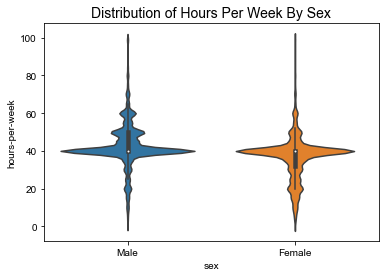

In [38]:
Distribution = sns.violinplot(data=data, x="sex", y="hours-per-week")
sns.set_style("darkgrid")
Distribution.set_title('Distribution of Hours Per Week By Sex', fontsize=14)

Text(0.5, 1.0, '(Balanced) Distribution of Hours Per Week By Sex')

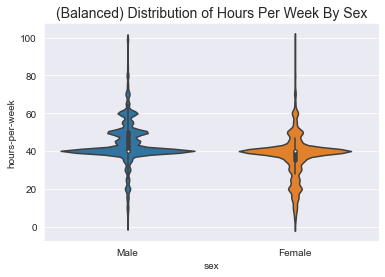

In [39]:
bDistribution = sns.violinplot(data=balanced_df, x="sex", y="hours-per-week")
sns.set_style("darkgrid")
bDistribution.set_title('(Balanced) Distribution of Hours Per Week By Sex', fontsize=14)

#### Explanation:
In regards to genders, both seem to have the same distribution for hours per week which is around 40 hours per week. The median for males is lower than the median for females. However, it can be seen that a majority of females work less than 40 hours per week as compared to males. A majority of males tend to work at or more than 40 hours per week compared to females.

### Kmeans

#### Original Graph

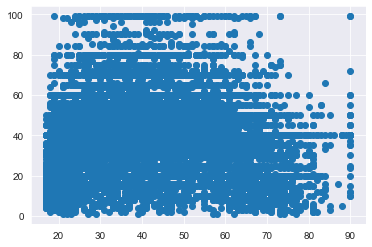

In [40]:
#x = age & y = hours per week
#without clustering
plt.scatter(data.age, data['hours-per-week'])

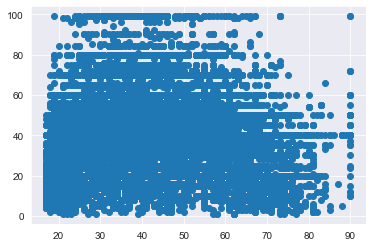

In [41]:
plt.scatter(balanced_df.age, balanced_df['hours-per-week'])

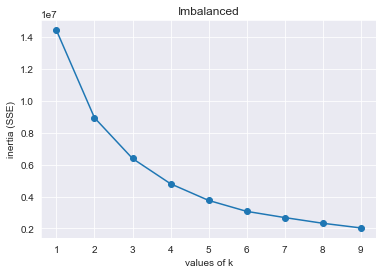

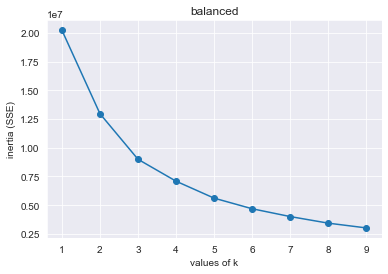

In [42]:
#finding the elbow graph
inertias = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters = k)
    kmeans.fit(data[['age','hours-per-week']])
    inertias.append(kmeans.inertia_)
    

plt.plot(range(1, 10), inertias, 'o-')
plt.xlabel('values of k')
plt.ylabel('inertia (SSE)')
plt.title("Imbalanced")
plt.show()


#balanced
binertias = []
for k in range(1, 10):
    bkmeans = KMeans(n_clusters = k)
    bkmeans.fit(balanced_df[['age','hours-per-week']])
    binertias.append(bkmeans.inertia_)
    

plt.plot(range(1, 10), binertias, 'o-')
plt.xlabel('values of k')
plt.ylabel('inertia (SSE)')
plt.title("balanced")
plt.show()

In [43]:
#new dataframe that has the column named "cluster" which will show which group cluster it belongs to
k_means = KMeans(n_clusters = 3)
k_means.fit(data[['age','hours-per-week']])
data['cluster'] = k_means.labels_
#data['cluster'] = predict_y
data.head()

age         workclass  fnlwgt  education  education-num  \
0   39         State-gov   77516  Bachelors             13   
1   50  Self-emp-not-inc   83311  Bachelors             13   
2   38           Private  215646    HS-grad              9   
3   53           Private  234721       11th              7   
4   28           Private  338409  Bachelors             13   

       marital-status         occupation   race     sex  capital-gain  \
0       Never-married       Adm-clerical  White    Male          2174   
1  Married-civ-spouse    Exec-managerial  White    Male             0   
2            Divorced  Handlers-cleaners  White    Male             0   
3  Married-civ-spouse  Handlers-cleaners  Black    Male             0   
4  Married-civ-spouse     Prof-specialty  Black  Female             0   

   capital-loss  hours-per-week native-country income  income-binary  cluster  
0             0              40  United-States  <=50K              0        1  
1             0              13  United-States  <=50K              0        2  
2             0              40  United-States  <=50K              0        1  
3             0              40  United-States  <=50K              0        2  
4             0              40           Cuba  <=50K              0        1

#### Graph with Cluster

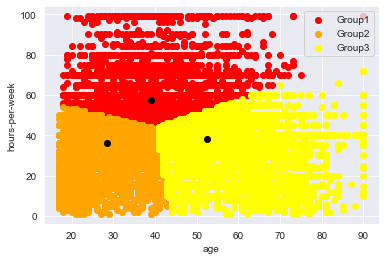

In [44]:
#assigning the three clusters into groups
dataCluster1 = data[data.cluster == 0]
dataCluster2 = data[data.cluster == 1]
dataCluster3 = data[data.cluster == 2]
#dataCluster4 = data[data.cluster == 3]



#graph the 3 clusters with their group
plt.scatter(dataCluster1.age,dataCluster1['hours-per-week'], color = 'red', label = "Group1")
plt.scatter(dataCluster2.age,dataCluster2['hours-per-week'], color = 'orange',label = "Group2")
plt.scatter(dataCluster3.age,dataCluster3['hours-per-week'], color = 'yellow', label = "Group3")
#plt.scatter(dataCluster4['hours-per-week'],dataCluster4.age, color = 'black')
centers = k_means.cluster_centers_

plt.scatter(centers[:, 0], centers[:, 1], c = 'black')

#, c = data['cluster']

plt.xlabel('age')
plt.ylabel('hours-per-week')
#plt.legend([dataCluster1, dataCluster2, dataCluster3], ["hours per week","hours per-week","hours-per week"])
plt.legend(loc="upper right")
#plt.show()

In [45]:
bk_means = KMeans(n_clusters = 3)
bk_means.fit(balanced_df[['age','hours-per-week']])
balanced_df['cluster'] = bk_means.labels_
#data['cluster'] = predict_y
balanced_df.head()

age         workclass  fnlwgt  education  education-num  \
0   39         State-gov   77516  Bachelors             13   
1   50  Self-emp-not-inc   83311  Bachelors             13   
2   38           Private  215646    HS-grad              9   
3   53           Private  234721       11th              7   
4   28           Private  338409  Bachelors             13   

       marital-status         occupation   race     sex  capital-gain  \
0       Never-married       Adm-clerical  White    Male          2174   
1  Married-civ-spouse    Exec-managerial  White    Male             0   
2            Divorced  Handlers-cleaners  White    Male             0   
3  Married-civ-spouse  Handlers-cleaners  Black    Male             0   
4  Married-civ-spouse     Prof-specialty  Black  Female             0   

   capital-loss  hours-per-week native-country income  income-binary  cluster  
0             0              40  United-States  <=50K              0        1  
1             0              13  United-States  <=50K              0        2  
2             0              40  United-States  <=50K              0        1  
3             0              40  United-States  <=50K              0        2  
4             0              40           Cuba  <=50K              0        1

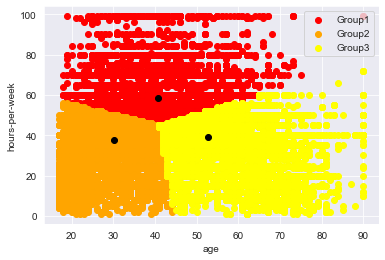

In [46]:
#assigning the three clusters into groups
dataCluster1 = balanced_df[balanced_df.cluster == 0]
dataCluster2 = balanced_df[balanced_df.cluster == 1]
dataCluster3 = balanced_df[balanced_df.cluster == 2]
#dataCluster4 = data[data.cluster == 3]



#graph the 3 clusters with their group
plt.scatter(dataCluster1.age,dataCluster1['hours-per-week'], color = 'red', label = "Group1")
plt.scatter(dataCluster2.age,dataCluster2['hours-per-week'], color = 'orange',label = "Group2")
plt.scatter(dataCluster3.age,dataCluster3['hours-per-week'], color = 'yellow', label = "Group3")
#plt.scatter(dataCluster4['hours-per-week'],dataCluster4.age, color = 'black')
centers = bk_means.cluster_centers_

plt.scatter(centers[:, 0], centers[:, 1], c = 'black')

#, c = data['cluster']

plt.xlabel('age')
plt.ylabel('hours-per-week')
#plt.legend([dataCluster1, dataCluster2, dataCluster3], ["hours per week","hours per-week","hours-per week"])
plt.legend(loc="upper right")
#plt.show()

#### Explanation:
We decided to find the Kmeans in terms of age and hours per week. Comparing the original graph with the new graph with clusters, we can see that there are 3 clusters in regards to hours per week. The first cluster, cluster 0, is shown as the red group1. The second cluster, cluster 1, is shown as the orange group2. Finally the third cluster, cluster 2, is shown as the yellow group3. Each cluster has a black dot which are the centers for each clusters.

### kNN

In [47]:
X = data[["age", "education-num","hours-per-week"]]
y = data["income"]
n=100
knnList = []

X_train, X_test, y_train, y_test = model_selection.train_test_split(
             X, y, test_size = 0.2, random_state=42)

for k in range(1,n):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    knnList.append(knn.score(X_test, y_test))

fig = px.line( x=range(1,n), y=knnList, title='Score of KNN for k')
fig.show()
knn = KNeighborsClassifier(n_neighbors=29)
knn.fit(X_train, y_train)
knn.score(X_test, y_test)

0.7838584853510226

In [48]:
X = balanced_df[["age", "education-num","hours-per-week"]]
y = balanced_df["income"]
n=100
bknnList = []

X_train, X_test, y_train, y_test = model_selection.train_test_split(
             X, y, test_size = 0.2, random_state=42)

for k in range(1,n):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    bknnList.append(knn.score(X_test, y_test))

bfig = px.line( x=range(1,n), y=bknnList, title='(Balanced) Score of KNN for k')
bfig.show()
bknn = KNeighborsClassifier(n_neighbors=29)
bknn.fit(X_train, y_train)
bknn.score(X_test, y_test)

0.7272526826400117

## Questions

1. Which of the following is NOT a pair of features we were concerned about regarding redundancy?  
    a. Education and education-num  
    b. **Workclass and occupation**  
    c. Relationship and marital-status  
2. How did we deal with the problem of imbalance classes?  
    a. **Randomly duplicate instances in minority class**  
    b. Randomly duplicate instances in majority class  
    c. Randomly duplicate instances in both majority and minority classes  
3. Why did we use logistic regression for correlation analysis?  
    a. The concerned features are both categorical  
    b. The concerned features are both continuous  
    c. **One feature is categorical and the other is continuous**  

## Contributions


* Stephen Dong:
    * Data Cleaning
        * Stripping to resolve inconsistant data values
        * Dropped rows with missing values
        * Marked or dropped redundant features
            * Algorithm: Logistic Regression
    * Correlation Analysis Between Numerical Features
        * Pearson's Correlation to see correlation between combinations of pairs of features
        * EDA: Scatterplot pairgrid to visually observe any correlations
* Ellie Cheng:
    * Data Cleaning: 
        * Resolved class imbalance:
            * compare counts of classes in original dataset, use random duplication of minority class to fix class imbalance
            * EDA: Bar Chart to visualize class imbalance
    * EDA: Heatmap visualization of Marital-status and occupation
    * Presentation: made questions about project
* Shashvat: 
    * EDA: Bubble visualization of education, age, occupation, and hours. Visualization of choosing k-value for KNN.
    * EDA: Line Graph for kNN score per k value
    * Algorithm: KNN model
* Selena Arias:
    * EDA: spider chart  visualization of race, sex, and marital for native-country (US vs other)
    * EDA: violinplot visualization -  group by sex and its distribution of hours per week
    * Algorithm: K-Means and its visualization

## Video Presentation
https://drive.google.com/file/d/1hoB8YU4CtBlRNwJxozmCcJohwaTVwW5B/view?usp=share_link